# Census Data - salary > $50k

# Loading the data

In [1]:
import os.path
import re
from urllib.request import urlopen
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data_url   = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/'
data_files = {'names': 'adult.names', 'train': 'adult.data', 'test':'adult.test'}
data_dir   = 'data/'
target     = 'income_level'


# check if data folder exists, otherwise create folder
if not os.path.isdir(data_dir):
    os.makedirs(data_dir)

def fetch_names(data_url):
    print(f'fetching data attributes from', data_url)
    def get_attr(line): return re.findall('^([a-zA-Z-]+):', line)[0].replace('-','_')
    with urlopen(data_url) as response:
        text = response.read().decode('utf-8')
        return [get_attr(s) for s in text.split('\n') if (len(s)>0 and s[0].isalpha())]

def download_data(data_url, names, dest):
    print(f'fetching data from', data_url)
    data = pd.read_csv(data_url, header=None, names=names)
    data.to_csv(dest, index=False)
    print(f'-> saved to {dest}')

# download training and test data
for x in ['train', 'test']:
    file = data_dir+'census_'+x+'.csv'
    if not os.path.isfile(file):
        names = fetch_names(data_url+data_files['names']) + [target]
        download_data(data_url+data_files[x], names=names, dest=file)

In [2]:
data = pd.read_csv('data/census_train.csv')

In [3]:
data.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_level
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
data.shape

(32561, 15)

In [5]:
from pandas_profiling import ProfileReport

report = ProfileReport(data)
report.to_file(outputfile="census_data_profile.html")

# Investigate Target Classes

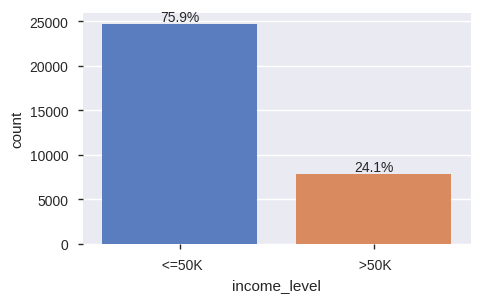

In [6]:
def show_percent(ax, ncount):
    """https://stackoverflow.com/questions/33179122/seaborn-countplot-with-frequencies"""
    for p in ax.patches:
        x = p.get_bbox().get_points()[:, 0]
        y = p.get_bbox().get_points()[1, 1]
        ax.annotate(
            "{:.1f}%".format(100.0 * y / ncount),
            (x.mean(), y),
            ha="center",
            va="bottom",
        )

fig, ax = plt.subplots(figsize=(5,3))
sns.countplot(data.income_level, palette="muted", ax=ax)
show_percent(ax, len(data.income_level))

## Encode Categorials

In [7]:
from sklearn.preprocessing import LabelEncoder

categorials = data.columns[data.dtypes == object].values
encoders = {col:LabelEncoder() for col in categorials}

for col in categorials:
    data[col] = encoders[col].fit_transform(data[col])

In [8]:
data.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_level
0,39,7,77516,9,13,4,1,1,4,1,2174,0,40,39,0
1,50,6,83311,9,13,2,4,0,4,1,0,0,13,39,0
2,38,4,215646,11,9,0,6,1,4,1,0,0,40,39,0
3,53,4,234721,1,7,2,6,0,2,1,0,0,40,39,0
4,28,4,338409,9,13,2,10,5,2,0,0,0,40,5,0


## Investigate Correlation

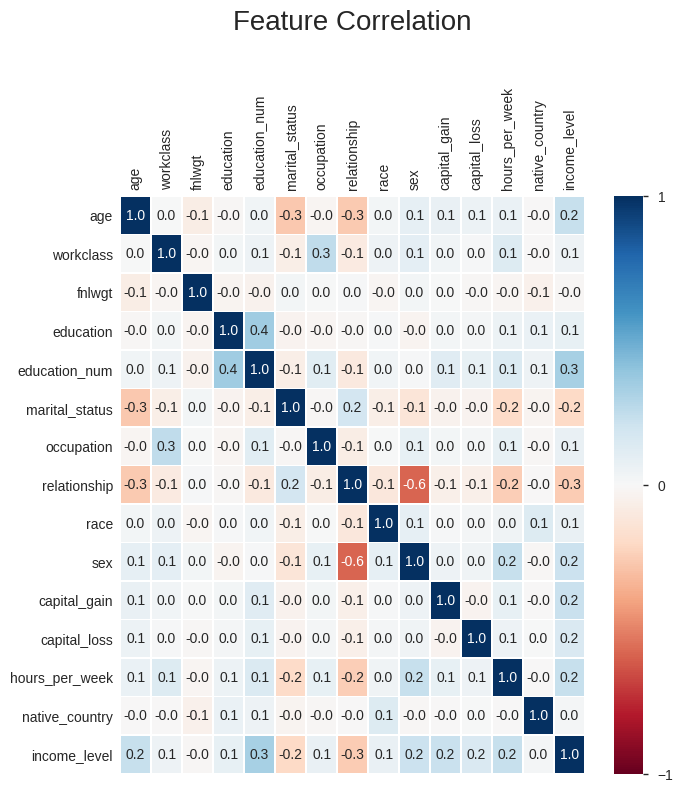

In [9]:
def corrplot(df, title=None):
    var_count = df.shape[1]
    fig, ax = plt.subplots(figsize=(var_count*0.5,var_count*0.5))
    sns.heatmap(df.corr(), vmin=-1, vmax=1, center=0, cmap='RdBu', annot=True, fmt= '.1f', linewidths=.5, ax=ax, cbar_kws={"ticks":[-1,0,1]});
    ax.tick_params(axis='x', which='major', labeltop=True, bottom=False, labelbottom=False, color='grey', rotation=90, pad=1.5)
    ax.tick_params(axis='y', which='major', left=False, color='grey', pad=1.5)
    plt.title(title,pad=120, size=20)

corrplot(data, 'Feature Correlation')

In [10]:
# pairplot of features - takes long to compute
#sns.pairplot(data, vars=data.columns[:-1], hue='income_level', diag_kind='hist', palette="muted");